In [3]:
import numpy as np 
import matplotlib.pyplot as plt 
import h5py 
import scipy 
from PIL import Image 
from scipy import ndimage 
from lr_utils import load_dataset 


Problem Statement: You are given a dataset ("data.h5") containing:

- a training set of m_train images labeled as cat (y=1) or non-cat (y=0)
- a test set of m_test images labeled as cat or non-cat
- each image is of shape (num_px, num_px, 3) where 3 is for the 3 channels (RGB). Thus, each image is square (height = num_px) and (width = num_px).

You will build a simple image-recognition algorithm that can correctly classify pictures as cat or non-cat.

Let's get more familiar with the dataset. Load the data by running the following code.

In [4]:
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

We added "_orig" at the end of image datasets (train and test) because we are going to preprocess them. After preprocessing, we will end up with train_set_x and test_set_x (the labels train_set_y and test_set_y don't need any preprocessing).

Each line of your train_set_x_orig and test_set_x_orig is an array representing an image. You can visualize an example by running the following code. Feel free also to change the index value and re-run to see other images.

y = [1], it's a 'cat' picture.


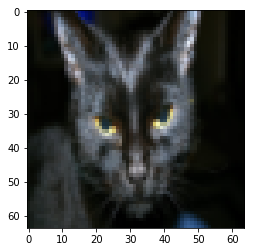

In [5]:
index = 25
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:,index]) + ", it's a '" + classes[np.squeeze(train_set_y[:,index])].decode("utf-8") +  "' picture.")



Many software bugs in deep learning come from having matrix/vector dimensions that don't fit. If you can keep your matrix/vector dimensions straight you will go a long way toward eliminating many bugs.

Exercise: Find the values for:

- m_train (number of training examples)
- m_test (number of test examples)
- num_px (= height = width of a training image)

Remember that train_set_x_orig is a numpy-array of shape (m_train, num_px, num_px, 3). For instance, you can access m_train by writing train_set_x_orig.shape[0].


In [6]:
m_train = train_set_y.shape[1]
m_test = test_set_y.shape[1]
num_px = train_set_x_orig.shape[1]

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


Exercise: Reshape the training and test data sets so that images of size (num_px, num_px, 3) are flattened into single vectors of shape (num_px $*$ num_px $*$ 3, 1).

A trick when you want to flatten a matrix X of shape (a,b,c,d) to a matrix X_flatten of shape (b$*$c$*$d, a) is to use:

X_flatten = X.reshape(X.shape[0], -1).T      # X.T is the transpose of X


In [7]:
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))
print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0]))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)
sanity check after reshaping: [17 31 56 22 33]




To represent color images, the red, green and blue channels (RGB) must be specified for each pixel, and so the pixel value is actually a vector of three numbers ranging from 0 to 255.

One common preprocessing step in machine learning is to center and standardize your dataset, meaning that you substract the mean of the whole numpy array from each example, and then divide each example by the standard deviation of the whole numpy array. But for picture datasets, it is simpler and more convenient and works almost as well to just divide every row of the dataset by 255 (the maximum value of a pixel channel).

Let's standardize our dataset.


In [8]:
train_set_x = train_set_x_flatten / 255.
test_set_x = test_set_x_flatten / 255.

t's time to design a simple algorithm to distinguish cat images from non-cat images.

You will build a Logistic Regression, using a Neural Network mindset. The following Figure explains why Logistic Regression is actually a very simple Neural Network!

![](images/vector.png)

Mathematical expression of the algorithm:

For one example $x^{(i)}$: $$z^{(i)} = w^T x^{(i)} + b \tag{1}$$ $$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ $$ \mathcal{L}(a^{(i)}, y^{(i)}) = - y^{(i)} \log(a^{(i)}) - (1-y^{(i)} ) \log(1-a^{(i)})\tag{3}$$

The cost is then computed by summing over all training examples: $$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{6}$$

Key steps: In this exercise, you will carry out the following steps:

- Initialize the parameters of the model
- Learn the parameters for the model by minimizing the cost  
- Use the learned parameters to make predictions (on the test set)
- Analyse the results and conclude

Exercise: Using your code from "Python Basics", implement sigmoid(). As you've seen in the figure above, you need to compute $sigmoid( w^T x + b)$ to make predictions.

In [2]:
def sigmoid(z):
    A = 1.0 / (1 + np.exp(-z))
    return A 

Exercise: Implement parameter initialization in the cell below. You have to initialize w as a vector of zeros. If you don't know what numpy function to use, look up np.zeros() in the Numpy library's documentation.

In [3]:
def initialize_with_zeros(dim):
#     将w初始化为dim行,1列的向量
    w = np.zeros((dim, 1))
    b = 0
    
    assert(w.shape == (dim, 1))
    
    return w, b

In [4]:
def image2vector(image):
    return image.reshape(image.shape[0], -1).T

Exercise: Implement a function propagate() that computes the cost function and its gradient.

Hints:

Forward Propagation:

You get X
You compute $A = \sigma(w^T X + b) = (a^{(0)}, a^{(1)}, ..., a^{(m-1)}, a^{(m)})$
You calculate the cost function: $J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$

Here are the two formulas you will be using:
$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T$$$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})$$

In [5]:
def propagate(w, b, X, Y):
    # z的维度为(1, X.shape[0])
    z = np.dot(w.T, X) + b
    A = sigmoid(z)
    
    m = X.shape[1]

#     计算代价
    cost = (-1.0 / m) * np.sum(Y * np.log(A) + (1 - Y) * np.log(1 - A))
#     计算dw, 样本中的数据X, 每列中代表一个样本的所有数据, 把每个样本数据的第一个数据提取出来乘(A - Y)的转置
#     相当于x11*a1 + x21*a2 + x31*a3 ...,计算完放入第一行, 行数取决于单个样本中的数据(特征向量维度), 这是个矩阵运算, 这样就不需要去求和了;
    dw = (1.0 / m) * np.dot(X, (A - Y).T)
    
    db = (1.0 / m) * np.sum(A - Y)
    
    grads = {"dw": dw,
             "db": db}
    return grads, cost

In [6]:
w, b, X, Y = np.array([[1.],[2.]]), 2., np.array([[1.,2., 1.],[3.,4., 3.2]]), np.array([[1,0,1]]) 

grads, cost = propagate(w, b, X, Y) 
print ("dw = " + str(grads["dw"])) 
print ("db = " + str(grads["db"])) 
print ("cost = " + str(cost))

dw = [[0.66659387]
 [1.33311351]]
db = 0.3332625813421866
cost = 4.000070755676173


***迭代***

In [7]:
def optimize(w, b, X, Y, num_iterations = 1000, learning_rate = 0.1, print_cost = False):
    
    cost = last_cost = 0;
    
    for i in range(num_iterations):
        last_cost = cost;
        
        grads, cost = propagate(w, b, X, Y)

        w -= grads["dw"] * learning_rate
        b -= grads["db"] * learning_rate

        if abs(cost - last_cost) < 1e-8:
            print("i is %d" % i)
            break
        
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" % (i , cost))
            
    params = {"w": w,
              "b": b}
    
    return params, grads, cost

In [8]:
params, grads, cost = optimize(w, b, X, Y, num_iterations= 100000, learning_rate = 0.3, print_cost = False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

i is 57326
w = [[-19.30403381]
 [  4.84566748]]
b = 12.001884117331313
dw = [[ 1.54478877e-04]
 [-4.06074522e-05]]
db = -8.842678665894873e-05
cost = 0.000574425692974283


In [9]:
def predict(w, b, X):
    m = X.shape[1]
    Y_prediction = np.zeros((1, m))
    
    z = np.dot(w.T, X) + b
    A = sigmoid(z)
    
    for i in range(A.shape[1]):
        
        if A[0][i] > 0.5:
            Y_prediction[0][i] = 1
        else:
            Y_prediction[0][i] = 0
            
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

In [10]:
w = np.array([[-19.30403381],[4.84566748]])
b = 12.001884117331313
X = np.array([[1., 1.1, 3.2],[1.2, 2.,0.1]])

print("predictions = " + str(predict(w, b, X)))

predictions = [[0. 1. 0.]]


In [11]:
def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    
    w, b = initialize_with_zeros(X_train.shape[0])
    
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)

    w = parameters["w"]
    b = parameters["b"]
    
    Y_prediction_train = predict(w, b, X_train)
    Y_prediction_test = predict(w, b, X_test)
    
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))


    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}

    return d

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.584508
Cost after iteration 200: 0.466949
Cost after iteration 300: 0.376007
Cost after iteration 400: 0.331463
Cost after iteration 500: 0.303273
Cost after iteration 600: 0.279880
Cost after iteration 700: 0.260042
Cost after iteration 800: 0.242941
Cost after iteration 900: 0.228004
Cost after iteration 1000: 0.214820
Cost after iteration 1100: 0.203078
Cost after iteration 1200: 0.192544
Cost after iteration 1300: 0.183033
Cost after iteration 1400: 0.174399
Cost after iteration 1500: 0.166521
Cost after iteration 1600: 0.159305
Cost after iteration 1700: 0.152667
Cost after iteration 1800: 0.146542
Cost after iteration 1900: 0.140872
train accuracy: 99.04306220095694 %
test accuracy: 70.0 %
y = 1, you predicted that it is a "cat" picture.
y = 1, you predicted that it is a "cat" picture.
y = 1, you predicted that it is a "cat" picture.
y = 1, you predicted that it is a "cat" picture.
y = 1, you predicted that it is a "cat

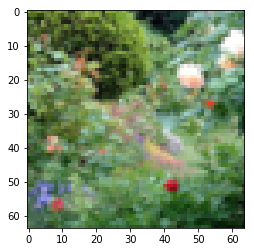

In [12]:
train_set_x_flatten = image2vector(train_set_x_orig)
test_set_x_flatten = image2vector(test_set_x_orig)

# 数据太大需要处理
train_set_x = train_set_x_flatten / 255.
test_set_x = test_set_x_flatten / 255.

d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)
num_px = train_set_x_orig.shape[1]

for i in range(test_set_x.shape[1]):
    plt.imshow(test_set_x[:,i].reshape((num_px, num_px, 3)))
    print ("y = " + str(test_set_y[0][i]) + ", you predicted that it is a \"" + classes[int(d["Y_prediction_test"][0][i])].decode("utf-8") +  "\" picture.")

/home/sourcelink/.local/lib/python3.5/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  


y = 1.0, your algorithm predicts a "cat" picture.


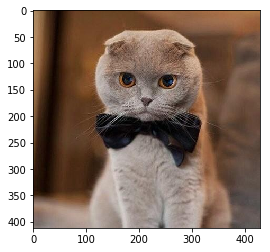

In [273]:
my_image = "other_test.jpg"   # change this to the name of your image file 

# We preprocess the image to fit your algorithm.
fname = "images/" + my_image

image = np.array(plt.imread(fname))

# 进程尺寸转换
my_image = scipy.misc.imresize(image, size=(num_px,num_px)).reshape((1, num_px * num_px * 3)).T

my_predicted_image = predict(d["w"], d["b"], my_image)

plt.imshow(image)

print("y = " + str(np.squeeze(my_predicted_image)) + ", your algorithm predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")